In [48]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter
import re
import seaborn as sns

In [49]:
train_df = pd.read_csv('dataset/TRAIN.csv', header=None, sep='\t', 
                  names=["Sequence"])

In [50]:
train_df.shape

(52499, 1)

In [51]:
word_dict = {}
word_pos_dict = {}
pos_dict = {}
sentences_list = {}

train_df["Sequence"] = train_df["Sequence"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

proper_nouns = []
numerical_patterns = []

date_pattern = r'\d{2}/\d{2}/\d{4}'  
time_pattern = r'\d{1,2}:\d{2}'  
amount_pattern = r'\d+\.\d+'  

for sequence in train_df["Sequence"]:
    sentences_list[len(sequence)] = sentences_list.get(len(sequence), 0) + 1

    for word, pos in sequence:
        word_dict[word] = word_dict.get(word, 0) + 1
        word_pos_dict[(word, pos)] = word_pos_dict.get((word, pos), 0) + 1
        pos_dict[pos] = pos_dict.get(pos, 0) + 1

        if pos == 'PROPN':
            proper_nouns.append(word)
        
        if pos == 'NUM':
            if re.match(date_pattern, word):
                numerical_patterns.append(f"Date: {word}")
            elif re.match(time_pattern, word):
                numerical_patterns.append(f"Time: {word}")
            elif re.match(amount_pattern, word):
                numerical_patterns.append(f"Amount: {word}")
            else:
                numerical_patterns.append(f"Number: {word}")

print("The number of words in the training set is: ", len(word_dict))
print("The number of sentences in the training set is: ", len(train_df))
print("The number of word-tag pairs in the training set is: ", len(word_pos_dict))
print("The number of unique POS tags in the training set is: ", len(pos_dict))

The number of words in the training set is:  58110
The number of sentences in the training set is:  52499
The number of word-tag pairs in the training set is:  65674
The number of unique POS tags in the training set is:  21


[('NOUN', 240200), ('VERB', 151833), ('ADP', 125188), ('DET', 115786), ('.', 94933), ('ADJ', 76692), ('ADV', 49059), ('PRON', 48875), ('CONJ', 27234), ('PUNCT', 23826), ('PROPN', 19556), ('PRT', 18688), ('NUM', 17148), ('X', 13180), ('AUX', 12771), ('PART', 7586), ('CCONJ', 6535), ('SCONJ', 3720), ('_', 2668), ('INTJ', 755), ('SYM', 739)]


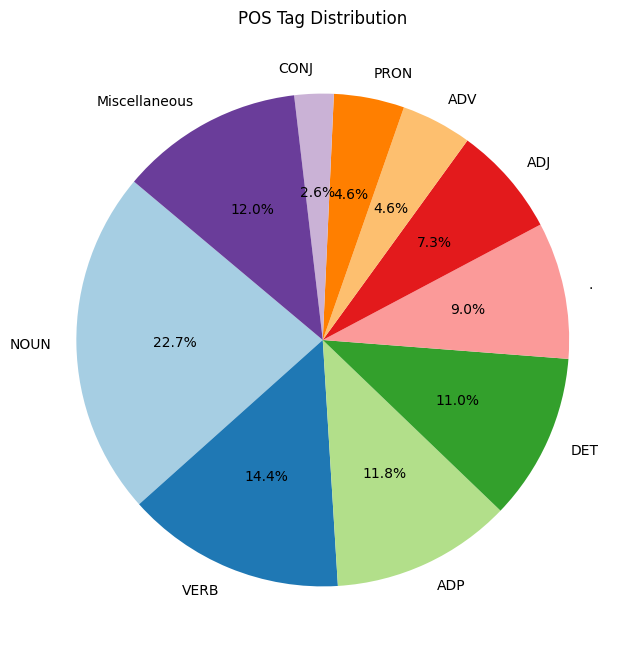

In [52]:
sorted_pos = sorted(pos_dict.items(), key=lambda x: x[1], reverse=True)

labels, values = zip(*sorted_pos)

print(sorted_pos)

top_n = 9
top_labels = [label for label, _ in sorted_pos[:top_n]]
top_values = [value for _, value in sorted_pos[:top_n]]

misc_value = sum(value for _, value in sorted_pos[top_n:])
top_labels.append("Miscellaneous")
top_values.append(misc_value)

plt.figure(figsize=(8, 8))
plt.pie(top_values, labels=top_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

plt.title("POS Tag Distribution")
plt.show()

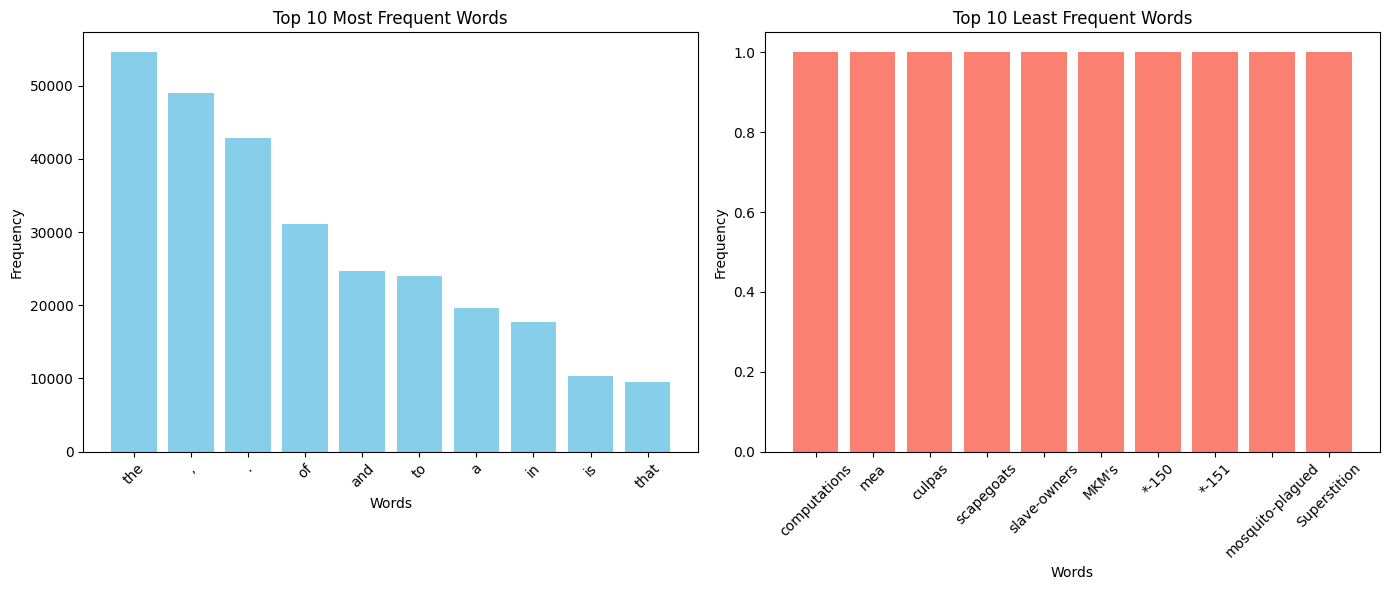

In [53]:
sorted_words = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

most_frequent_words = sorted_words[:10]
least_frequent_words = sorted_words[-10:]

most_labels, most_values = zip(*most_frequent_words)
least_labels, least_values = zip(*least_frequent_words)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(most_labels, most_values, color='skyblue')
axes[0].set_title("Top 10 Most Frequent Words")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(least_labels, least_values, color='salmon')
axes[1].set_title("Top 10 Least Frequent Words")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

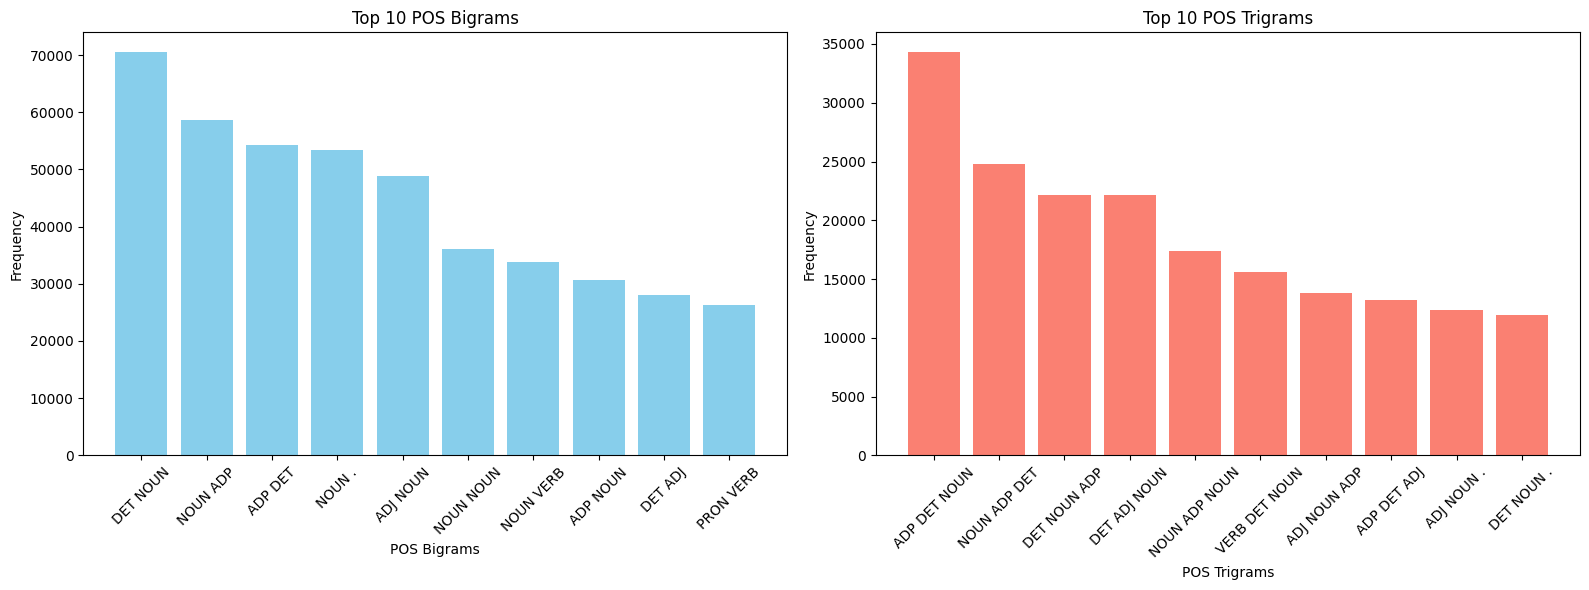

In [54]:
pos_sequences_bigram = {}
pos_sequences_trigram = {}
pos_sequences_punctuation = {}

start_punctuation = {}
middle_punctuation = {}
end_punctuation = {}

for sequence in train_df["Sequence"]:
    word_queue = []
    pos_queue = []

    index = 0
    for word in sequence:
        pos_queue.append(word[1])

        if index == 0 and word[1] == "PUNCT":
            start_punctuation[word[0]] = start_punctuation.get(word[0], 0) + 1
        elif index == len(sequence) - 1 and word[1] == "PUNCT":
            end_punctuation[word[0]] = end_punctuation.get(word[0], 0) + 1
        elif word[1] == "PUNCT":
            middle_punctuation[word[0]] = middle_punctuation.get(word[0], 0) + 1

        if len(pos_queue) >= 2:
            bigram = " ".join(pos_queue[-2:])
            pos_sequences_bigram[bigram] = pos_sequences_bigram.get(bigram, 0) + 1

        if len(pos_queue) >= 3: 
            trigram = " ".join(pos_queue[-3:])
            pos_sequences_trigram[trigram] = pos_sequences_trigram.get(trigram, 0) + 1

        if index == 0 and pos_queue[-1] == "PUNCT":
            unigram = " ".join(pos_queue[-1:])
            pos_sequences_punctuation[unigram] = pos_sequences_punctuation.get(unigram, 0) + 1
        elif (index == len(sequence) - 1 or index == 1) and pos_queue[-1] == "PUNCT":
            bigram = " ".join(pos_queue[-2:])
            pos_sequences_punctuation[bigram] = pos_sequences_punctuation.get(bigram, 0) + 1
        elif len(pos_queue) >= 2 and index < len(sequence) - 1 and pos_queue[-2] == "PUNCT":
            trigram = " ".join(pos_queue[-3:])
            pos_sequences_punctuation[trigram] = pos_sequences_punctuation.get(trigram, 0) + 1

        index += 1

sorted_bigrams = sorted(pos_sequences_bigram.items(), key=lambda x: x[1], reverse=True)
sorted_trigrams = sorted(pos_sequences_trigram.items(), key=lambda x: x[1], reverse=True)

top_bigrams = sorted_bigrams[:10]
top_trigrams = sorted_trigrams[:10]

bigram_labels, bigram_values = zip(*top_bigrams)
trigram_labels, trigram_values = zip(*top_trigrams)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(bigram_labels, bigram_values, color='skyblue')
axes[0].set_title("Top 10 POS Bigrams")
axes[0].set_xlabel("POS Bigrams")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(trigram_labels, trigram_values, color='salmon')
axes[1].set_title("Top 10 POS Trigrams")
axes[1].set_xlabel("POS Trigrams")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

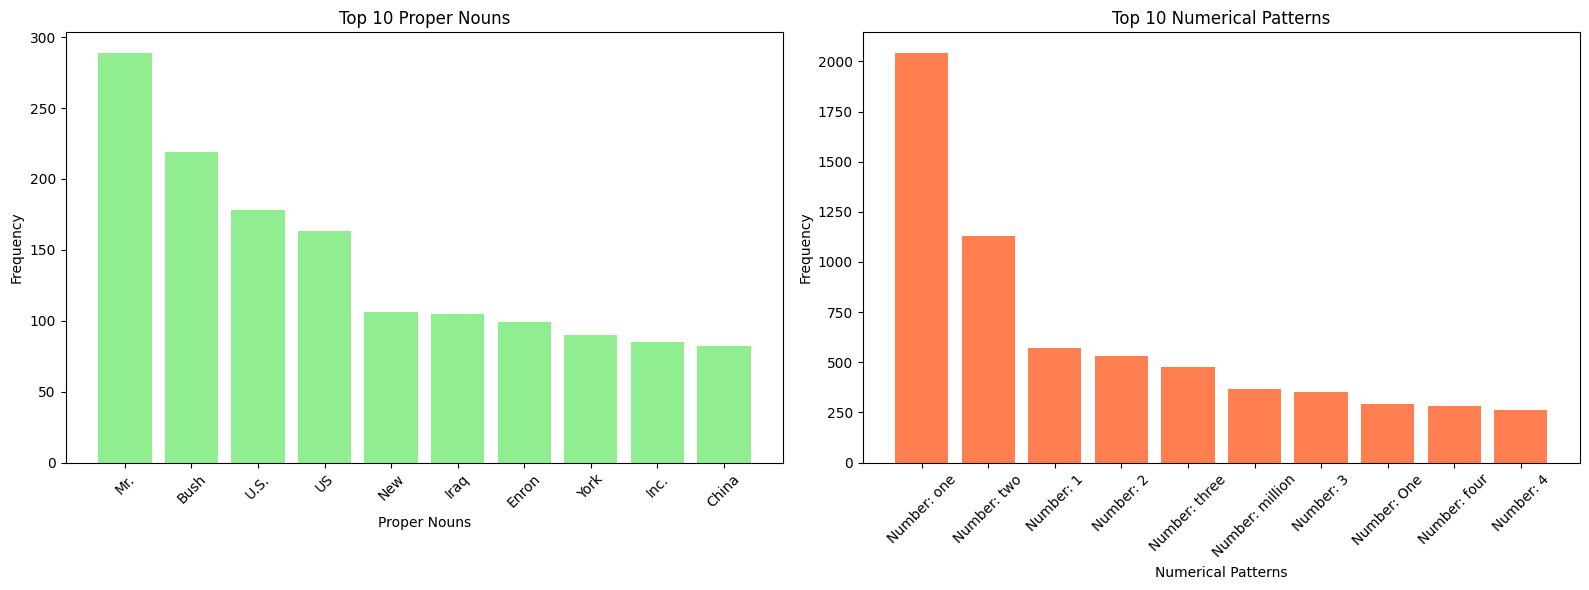

In [55]:
proper_noun_counts = Counter(proper_nouns)
numerical_pattern_counts = Counter(numerical_patterns)

top_proper_nouns = proper_noun_counts.most_common(10)
top_numerical_patterns = numerical_pattern_counts.most_common(10)

proper_noun_labels, proper_noun_values = zip(*top_proper_nouns)
numerical_pattern_labels, numerical_pattern_values = zip(*top_numerical_patterns)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(proper_noun_labels, proper_noun_values, color='lightgreen')
axes[0].set_title("Top 10 Proper Nouns")
axes[0].set_xlabel("Proper Nouns")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(numerical_pattern_labels, numerical_pattern_values, color='coral')
axes[1].set_title("Top 10 Numerical Patterns")
axes[1].set_xlabel("Numerical Patterns")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()


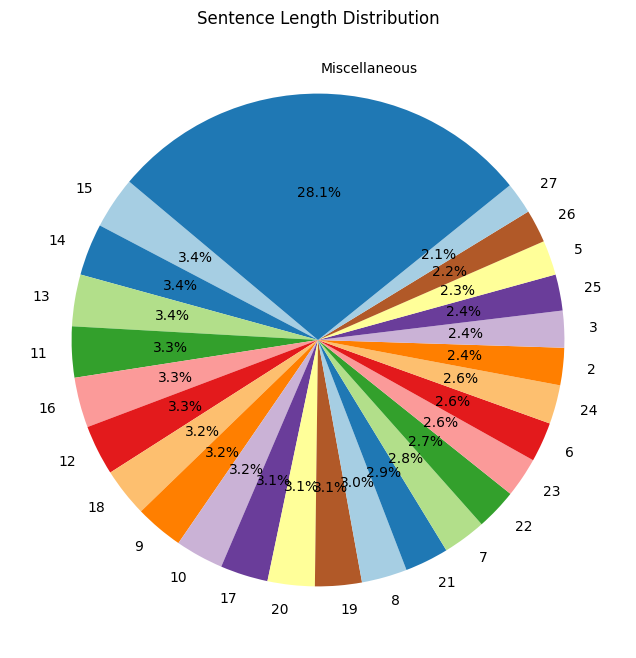

In [56]:
sorted_sentences_list = sorted(sentences_list.items(), key=lambda x: x[1], reverse=True)

labels, values = zip(*sorted_sentences_list)

top_n = 25
top_labels = [label for label, _ in sorted_sentences_list[:top_n]]
top_values = [value for _, value in sorted_sentences_list[:top_n]]

misc_value = sum(value for _, value in sorted_sentences_list[top_n:])
top_labels.append("Miscellaneous")
top_values.append(misc_value)

plt.figure(figsize=(8, 8))
plt.pie(top_values, labels=top_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

plt.title("Sentence Length Distribution")
plt.show()

In [57]:
sorted_pos_punctuation = sorted(pos_sequences_punctuation.items(), key=lambda x: x[1], reverse=True)

sorted_pos_punctuation

[('NOUN PUNCT', 5210),
 ('PROPN PUNCT', 1411),
 ('ADV PUNCT', 1064),
 ('VERB PUNCT', 998),
 ('ADJ PUNCT', 949),
 ('NOUN PUNCT NOUN', 673),
 ('PRON PUNCT', 671),
 ('NOUN PUNCT CCONJ', 625),
 ('PROPN PUNCT PROPN', 625),
 ('NOUN PUNCT PRON', 586),
 ('PUNCT PUNCT', 572),
 ('PUNCT', 509),
 ('NUM PUNCT', 470),
 ('NOUN PUNCT VERB', 395),
 ('NOUN PUNCT ADV', 351),
 ('NOUN PUNCT DET', 288),
 ('NOUN PUNCT ADP', 264),
 ('NUM PUNCT NOUN', 255),
 ('NOUN PUNCT PROPN', 241),
 ('NOUN PUNCT ADJ', 226),
 ('NOUN PUNCT PUNCT', 215),
 ('INTJ PUNCT', 210),
 ('ADP PUNCT', 202),
 ('PROPN PUNCT PRON', 192),
 ('ADJ PUNCT ADJ', 184),
 ('PROPN PUNCT CCONJ', 183),
 ('ADV PUNCT PRON', 172),
 ('NOUN PUNCT SCONJ', 163),
 ('NOUN PUNCT AUX', 140),
 ('PROPN PUNCT DET', 140),
 ('NOUN PUNCT NUM', 140),
 ('ADJ PUNCT NOUN', 138),
 ('ADJ PUNCT CCONJ', 132),
 ('PROPN PUNCT VERB', 128),
 ('NUM PUNCT NUM', 115),
 ('VERB PUNCT PRON', 114),
 ('PROPN PUNCT PUNCT', 108),
 ('PROPN PUNCT NOUN', 103),
 ('VERB PUNCT CCONJ', 101),
 ('PR

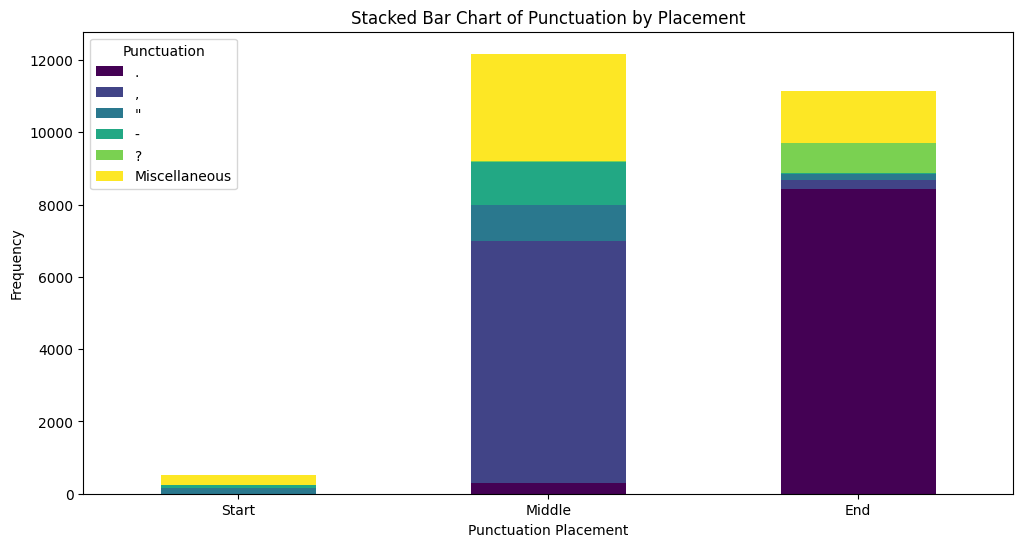

In [58]:
top_n = 5  

all_punctuation = {**start_punctuation, **middle_punctuation, **end_punctuation}

sorted_punctuation = sorted(all_punctuation.items(), key=lambda x: sum([
    start_punctuation.get(x[0], 0),
    middle_punctuation.get(x[0], 0),
    end_punctuation.get(x[0], 0)
]), reverse=True)

top_punctuations = [p[0] for p in sorted_punctuation[:top_n]]

data = []
for punct in top_punctuations:
    data.append([
        punct,
        start_punctuation.get(punct, 0),
        middle_punctuation.get(punct, 0),
        end_punctuation.get(punct, 0)
    ])

miscellaneous_start = sum([start_punctuation.get(p, 0) for p in all_punctuation.keys() if p not in top_punctuations])
miscellaneous_middle = sum([middle_punctuation.get(p, 0) for p in all_punctuation.keys() if p not in top_punctuations])
miscellaneous_end = sum([end_punctuation.get(p, 0) for p in all_punctuation.keys() if p not in top_punctuations])

data.append(["Miscellaneous", miscellaneous_start, miscellaneous_middle, miscellaneous_end])

df = pd.DataFrame(data, columns=["Punctuation", "Start", "Middle", "End"])

df.set_index("Punctuation", inplace=True)

df.T.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

plt.xlabel("Punctuation Placement")
plt.ylabel("Frequency")
plt.title("Stacked Bar Chart of Punctuation by Placement")
plt.legend(title="Punctuation")
plt.xticks(rotation=0)
plt.show()

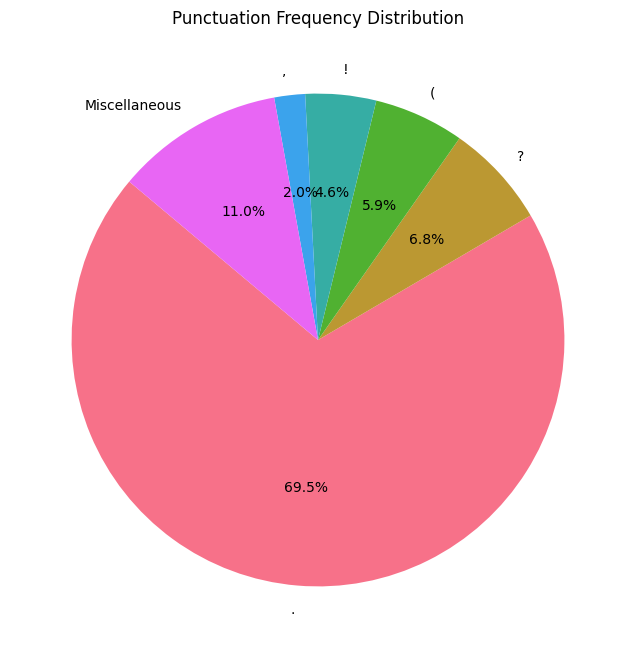

In [59]:
all_punctuation = {**start_punctuation, **middle_punctuation, **end_punctuation}

sorted_punctuation = sorted(all_punctuation.items(), key=lambda x: x[1], reverse=True)
top_n = 5
top_punctuation_labels, top_punctuation_values = zip(*sorted_punctuation[:top_n])
miscellaneous_value = sum([freq for _, freq in sorted_punctuation[top_n:]])

top_punctuation_labels = list(top_punctuation_labels) + ["Miscellaneous"]
top_punctuation_values = list(top_punctuation_values) + [miscellaneous_value]

colors = sns.color_palette("husl", len(top_punctuation_labels))

plt.figure(figsize=(8, 8))
plt.pie(top_punctuation_values, labels=top_punctuation_labels, autopct='%1.1f%%', startangle=140, colors=colors)

plt.title("Punctuation Frequency Distribution")

plt.show()

        Category  Count
0           Date    143
1           Time    404
2        Decimal    641
3        Integer   9283
4       Fraction      0
5    Word_Number   6451
6  Miscellaneous    226


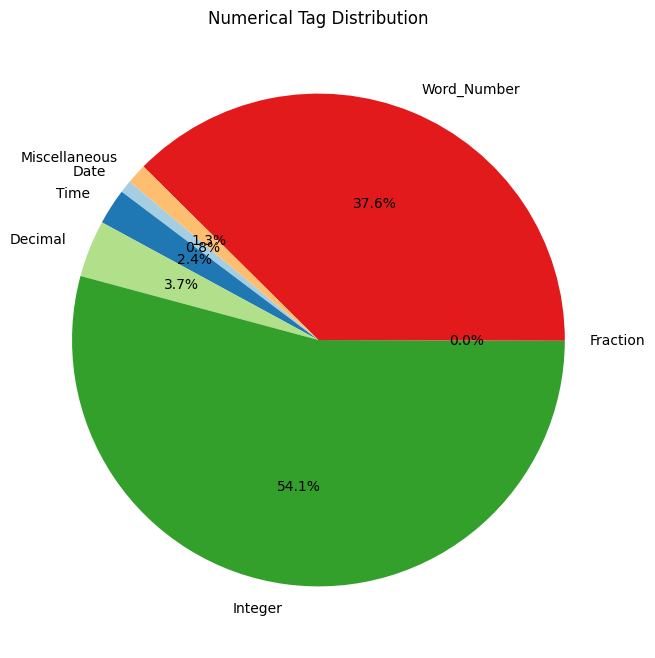

In [60]:
patterns = {
    "Date": r"\b\d{2}/\d{2}/\d{4}\b",
    "Time": r"\b\d{1,2}:\d{2}\b",
    "Decimal": r"\b\d+\.\d+\b",
    "Integer": r"\b\d+\b",
    "Fraction": r"\b\d+/\d+\b",
    "Word_Number": r"^[a-zA-Z]+$",
}

numerical_counts = {category: 0 for category in patterns.keys()}
numerical_counts["Miscellaneous"] = 0  

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        if pos == "NUM":
            categorized = False
            for category, pattern in patterns.items():
                if re.match(pattern, word):
                    numerical_counts[category] += 1
                    categorized = True
                    break
            if not categorized:
                numerical_counts["Miscellaneous"] += 1  

num_distribution_df = pd.DataFrame(numerical_counts.items(), columns=["Category", "Count"])

print(num_distribution_df)

plt.figure(figsize=(8, 8))

plt.pie(
    num_distribution_df["Count"], 
    labels=num_distribution_df["Category"], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title("Numerical Tag Distribution")
plt.show()

The number of unique words in SCONJ and CCONJ but NOT in CONJ is: 37
The number of non-unique words in SCONJ or Conj and in CONJ is: 44


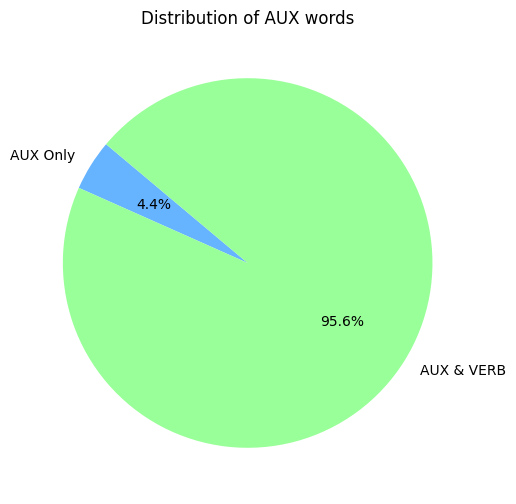

In [61]:
aux_words = set()
verb_words = set()

aux_count = 0
verb_count = 0
unique_count = 0

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        if pos == "AUX":
            aux_words.add(word.lower())
        elif pos == "VERB":
            verb_words.add(word.lower())

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        if pos == "AUX" and word not in verb_words:
            aux_count += 1
        elif pos == "AUX":
            verb_count += 1
        if pos == "VERB" and word not in aux_words:
            unique_count += 1

unique_aux = aux_words - verb_words
shared_verbs = verb_words & (aux_words)

print("The number of unique words in SCONJ and CCONJ but NOT in CONJ is:", len(unique_aux))
print("The number of non-unique words in SCONJ or Conj and in CONJ is:", len(shared_verbs))

labels = ['AUX Only', 'AUX & VERB']
sizes = [aux_count, verb_count]
colors = ['#66b3ff', '#99ff99']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of AUX words')
plt.show()

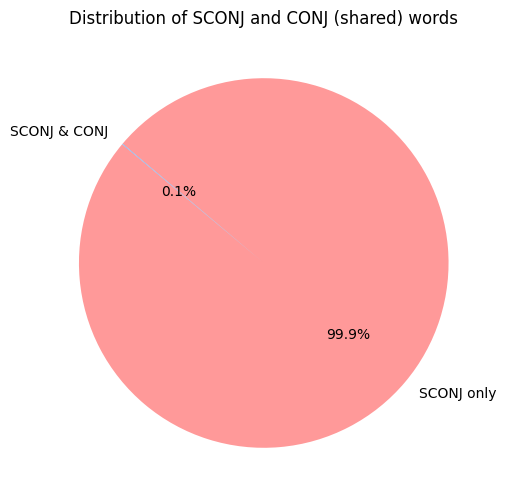

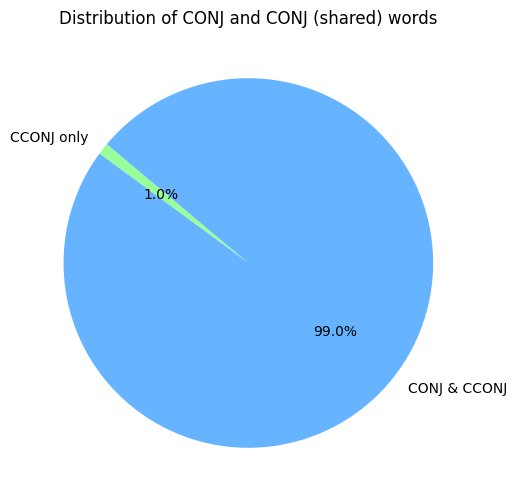

In [62]:
import matplotlib.pyplot as plt

sconj_words = set()
cconj_words = set()
conj_words = set()

sconj_count = 0
cconj_count = 0
shared_sconj_count = 0
shared_cconj_count = 0

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        lower_word = word.lower()
        if pos == "SCONJ":
            sconj_words.add(lower_word)
        elif pos == "CCONJ":
            cconj_words.add(lower_word)
        elif pos == "CONJ":
            conj_words.add(lower_word)

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        lower_word = word.lower()
        if pos == "SCONJ" and lower_word not in conj_words:
            sconj_count += 1
        elif pos == "SCONJ":
            shared_sconj_count += 1

        if pos == "CCONJ" and lower_word not in conj_words:
            cconj_count += 1
        elif pos == "CCONJ":
            shared_cconj_count += 1

unique_sconj_cconj = (sconj_words | cconj_words) - conj_words
shared_sconj_cconj = (sconj_words | cconj_words) & conj_words

labels = ['SCONJ only', 'SCONJ & CONJ']
sizes = [sconj_count, shared_sconj_count]
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of SCONJ and CONJ (shared) words')
plt.show()

labels = ['CCONJ only', 'CONJ & CCONJ']
sizes = [cconj_count, shared_cconj_count]
colors = ['#99ff99', '#66b3ff']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of CONJ and CONJ (shared) words')
plt.show()

The number of unique PRT words (not shared with PART): 171
The number of PRT words shared with PART: 1
The number of PART words never seen as PRT: 17
shared_prt_part: {'to'}


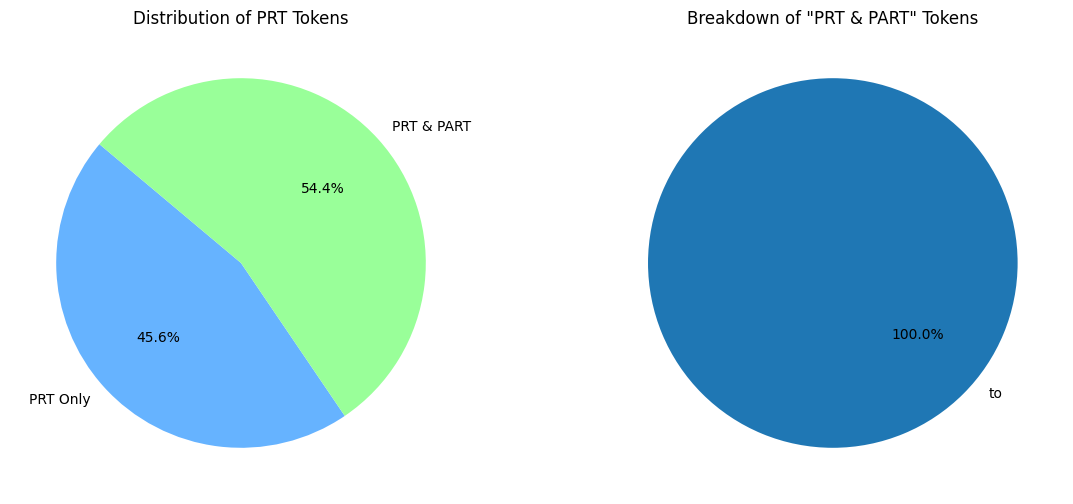

In [68]:
prt_words = set()
part_words = set()
prt_count = 0
part_count = 0
unique_count = 0

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        lower_word = word.lower()
        if pos == "PRT":
            prt_words.add(lower_word)
        elif pos == "PART":
            part_words.add(lower_word)

for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        lower_word = word.lower()
        if pos == "PRT":
            if lower_word not in part_words:
                prt_count += 1
            else:
                part_count += 1
        if pos == "PART" and lower_word not in prt_words:
            unique_count += 1

unique_prt = prt_words - part_words
shared_prt_part = prt_words & part_words

print("The number of unique PRT words (not shared with PART):", len(unique_prt))
print("The number of PRT words shared with PART:", len(shared_prt_part))
print("The number of PART words never seen as PRT:", len(part_words - prt_words))
print("shared_prt_part:", shared_prt_part)

shared_counts = {}
for sequence in train_df["Sequence"]:
    for word, pos in sequence:
        lower_word = word.lower()
        if pos == "PRT" and lower_word in shared_prt_part:
            shared_counts[lower_word] = shared_counts.get(lower_word, 0) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
labels_main = ['PRT Only', 'PRT & PART']
sizes_main = [prt_count, part_count]
colors_main = ['#66b3ff', '#99ff99']
ax1.pie(sizes_main, labels=labels_main, autopct='%1.1f%%', startangle=140, colors=colors_main)
ax1.set_title('Distribution of PRT Tokens')

labels_shared = list(shared_counts.keys())
sizes_shared = list(shared_counts.values())
ax2.pie(sizes_shared, labels=labels_shared, autopct='%1.1f%%', startangle=140)
ax2.set_title('Breakdown of "PRT & PART" Tokens')

plt.show()
